<a href="https://colab.research.google.com/github/june-oh/2023_AI_Academy_ASR/blob/main/4_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN & CTC

```
!wget https://github.com/june-oh/2023_AI_Academy_ASR/raw/main/set.wav
```

In [4]:
!wget https://github.com/june-oh/2023_AI_Academy_ASR/raw/main/set.wav

--2023-02-08 05:34:06--  https://github.com/june-oh/2023_AI_Academy_ASR/raw/main/set.wav
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/june-oh/2023_AI_Academy_ASR/main/set.wav [following]
--2023-02-08 05:34:06--  https://raw.githubusercontent.com/june-oh/2023_AI_Academy_ASR/main/set.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18998 (19K) [audio/wav]
Saving to: ‘set.wav.1’

set.wav.1           100%[===================>]  18.55K  --.-KB/s    in 0.001s  

2023-02-08 05:34:06 (27.5 MB/s) - ‘set.wav.1’ saved [18998/18998]



In [7]:
!ls

sample_data  set.wav


In [8]:
import torch
import torchaudio  #feature extraction
import torch.nn as nn   # RNN module 
import IPython.display as ipd
import matplotlib.pyplot as plt  #for visualization

In [9]:
ipd.Audio("set.wav")

In [10]:
y,sr = torchaudio.load("set.wav")
y,sr

(tensor([[ 0.0000e+00,  6.1035e-05, -3.0518e-05,  ...,  3.0518e-05,
           1.2207e-04, -1.5259e-04]]), 16000)

In [11]:
y.shape

torch.Size([1, 9424])

check duration(second)

In [12]:
y.shape[1]/ sr

0.589

In [13]:
??torchaudio.transforms.MelSpectrogram

In [14]:
n_fft = 512
hop_length = n_fft // 2
n_mels = 64
sr = 16000

mel_converter = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,
                                                     n_mels=n_mels,
                                                     sample_rate=sr,
                                                     hop_length=hop_length)

db_convert = torchaudio.transforms.AmplitudeToDB()



In [16]:
spec = mel_converter(y)
spec.shape

torch.Size([1, 64, 37])

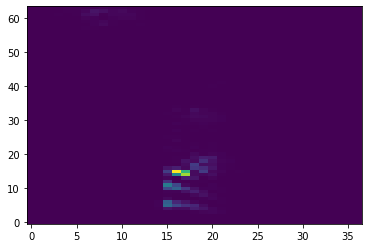

In [21]:
plt.imshow(spec[0],origin="lower",interpolation='nearest',aspect='auto')

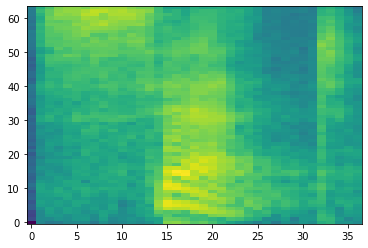

In [22]:
db_spec =db_convert(spec)
plt.imshow(db_spec[0],origin="lower",interpolation='nearest',aspect='auto')

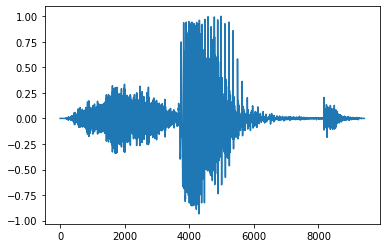

In [24]:
plt.plot(y[0])

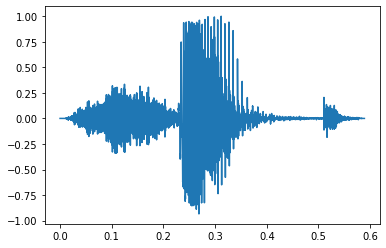

In [25]:
x = torch.arange(len(y[0]))/sr
plt.plot(x,y[0])

# gen character dict
```
'a' : 1 , 'b' : 2 , 'c':3 ... 'z':26
```

In [26]:
import string

In [32]:
char_set = dict(zip(string.ascii_lowercase,range(1,27)))
char_set['blk']=0

In [34]:
char_set

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'blk': 0}

### torch.nn.RNN

- input: tensor of shape $(L,H_{in})$ for unbatched input, $(L,N,H_{in}​)$ when `batch_first=False` or $(N,L,H_{in}​)$ when batch_first=True containing the features of the input sequence. The input can also be a packed variable length sequence. See `torch.nn.utils.rnn.pack_padded_sequence()` or `torch.nn.utils.rnn.pack_sequence()` for details.

$$
\begin{aligned}
N =& \text{batch size} \\
L =& \text{sequence length} \\
H_{in} =& \text{input_size} \\
\end{aligned}
$$



#arg of nn.RNN
>input_size: The number of expected features in the input `x`
>        
>hidden_size: The number of features in the hidden state `h`
>        
>num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
>            would mean stacking two RNNs together to form a `stacked RNN`,
>            with the second RNN taking in outputs of the first RNN and
>            computing the final results. Default: 1

In [67]:
??nn.Softmax

In [36]:
db_spec.shape

torch.Size([1, 64, 37])

In [96]:
class RNNModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.n_classes = 27 # # of char_set 
    self.n_fft = 512
    self.n_mels = 64      # input_size of nn.RNN
    self.hop_length = n_fft // 2
    self.sr = 16000
    self.hidden_dim = 64
    self.n_char = 27

    self.mel_converter = torchaudio.transforms.MelSpectrogram(n_fft =self.n_fft,
                                                              n_mels = self.n_mels,
                                                              hop_length=self.hop_length,
                                                              sample_rate=self.sr
                                                              )
    self.db_converter  = torchaudio.transforms.AmplitudeToDB()

    self.rnn = nn.RNN(self.n_mels, self.hidden_dim, 2, batch_first=True)
    self.output_layer = nn.RNN(self.hidden_dim,self.n_char,1,batch_first=True)
    self.softmax = nn.Softmax(dim=-1)


  def forward(self,x):
    #featrue extraction
    x = self.mel_converter(x)
    x = self.db_converter(x)
    x = x.transpose(1,2)
    x, _ = self.rnn(x)
    x, _ = self.output_layer(x)
    x = torch.nn.functional.log_softmax(x,dim=-1)

    return x

    #layer forward-propagatino

    


In [97]:
db_spec.shape     # [1,64,37]

db_spec.transpose(1,2).shape

torch.Size([1, 37, 64])

In [98]:
model = RNNModel()

In [99]:
out = model(y)

In [100]:
type(out)

torch.Tensor

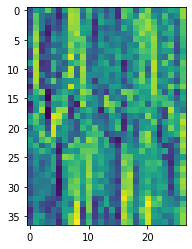

In [101]:
plt.imshow(out.cpu().detach().numpy()[0])

In [102]:
char_list = sorted(char_set, key = lambda x: char_set[x])

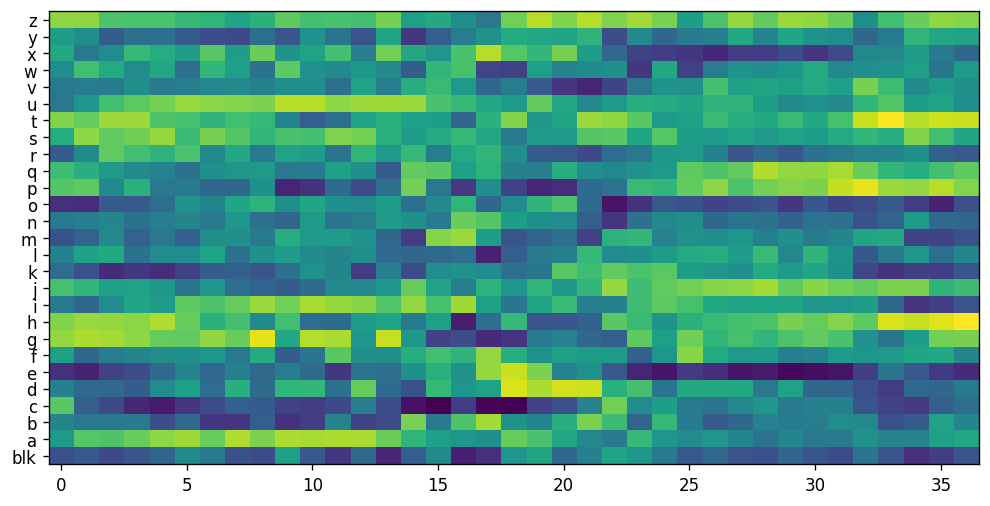

In [103]:
plt.figure(figsize=(10,5),dpi=120)
plt.imshow(out[0].detach().numpy().T,aspect='auto',interpolation='nearest',origin='lower')
ax = plt.gca()
ax.set_yticks(range(0,27))
ax.set_yticklabels(char_list)
plt.show()

In [107]:
??nn.CTCLoss

In [106]:
torch.tensor([[char_set['s'],char_set['e'],char_set['t']]]).shape

torch.Size([1, 3])

tensor([[19,  5, 20]]) tensor([[3]])
torch.Size([1, 3]) torch.int64


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

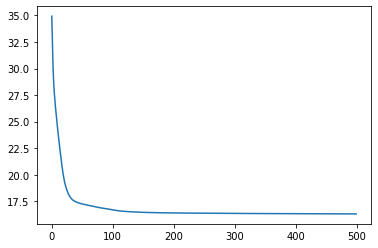

In [119]:
from tqdm.auto import tqdm


num_epoch =500
ctc_loss = nn.CTCLoss()  # CTC loss, loss_fn

target = torch.tensor([[char_set['s'],char_set['e'],char_set['t']]],dtype=torch.int64)  # set -> 19,5,20
target_lengths=torch.tensor([[3]])  # target length = 3 
print(target,target_lengths)
y,sr = torchaudio.load("set.wav")  #datset 에 위치해야하는 statement 
batch = [[y,target]]
print(target.shape,target.dtype)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=RNNModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
#out = torch.randn((37,27))
losses = []
#ctc_loss = nn.CTCLoss()
input_lengths = torch.tensor(37)

pbar = tqdm(range(num_epoch))
for e in  pbar:  
  for sample in batch:    
    x,y = sample
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    #print(input.shape)
    #pred = torch.argmax(input, dim=-1)
    #logit = torch.zeros_like(input).scatter_(1, pred.unsqueeze(1), 1.)    
    #input_lengths = torch.tensor([input.shape[1]])
    #print(pred.shape, target.shape, input_lengths, target_lengths)
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(losses)

In [120]:
wav, sr = torchaudio.load("set.wav")
out = model(wav)

In [128]:
def plot_ctc(out,epoch) :
  plt.figure(figsize=(8,4),dpi=100)
  plt.imshow(out[0].detach().numpy().T,aspect='auto',interpolation='nearest',origin='lower')
  plt.title(f"epoch : {epoch}")
  ax = plt.gca()
  ax.set_yticks(range(0,27))
  ax.set_yticklabels(char_list)
  plt.colorbar()
  plt.show()


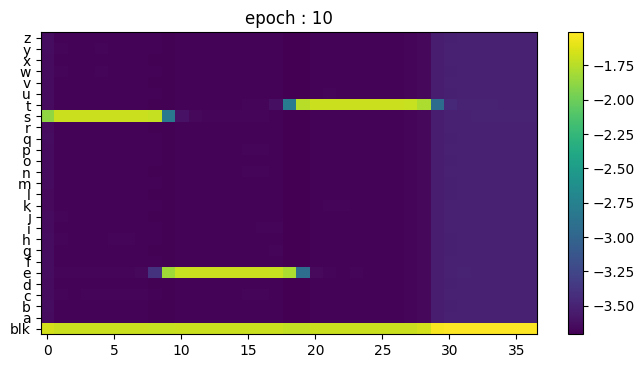

In [129]:
plot_ctc(out,10)

tensor([[19,  5, 20]]) tensor([[3]])
torch.Size([1, 3]) torch.int64


  0%|          | 0/500 [00:00<?, ?it/s]

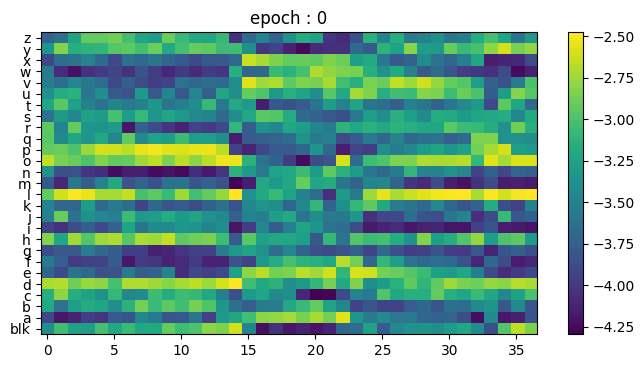

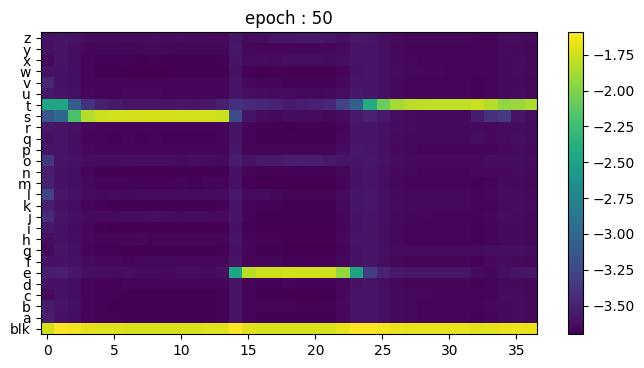

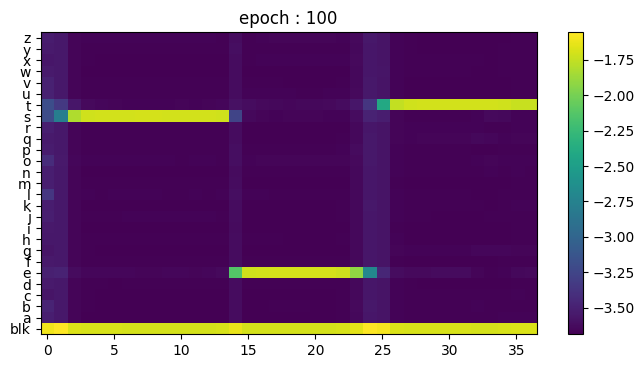

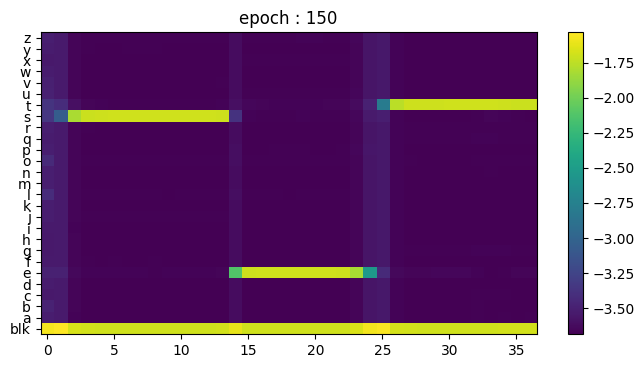

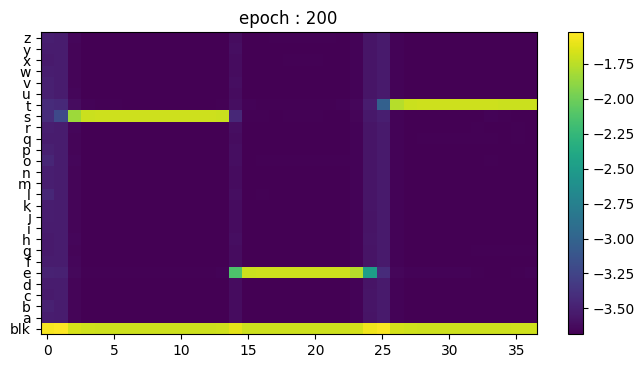

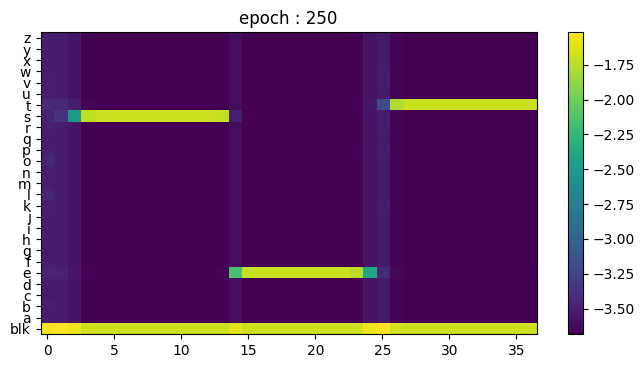

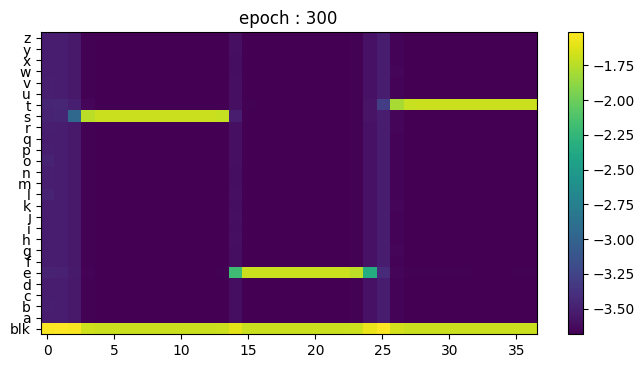

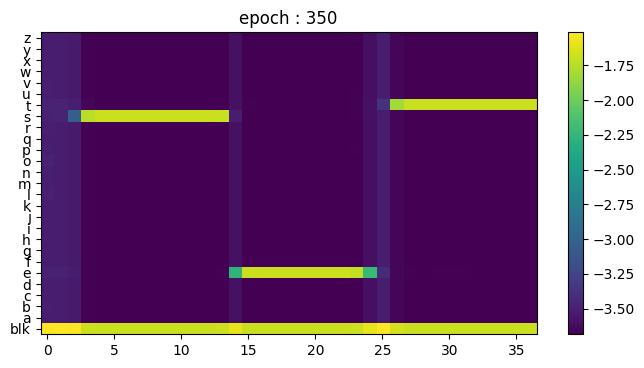

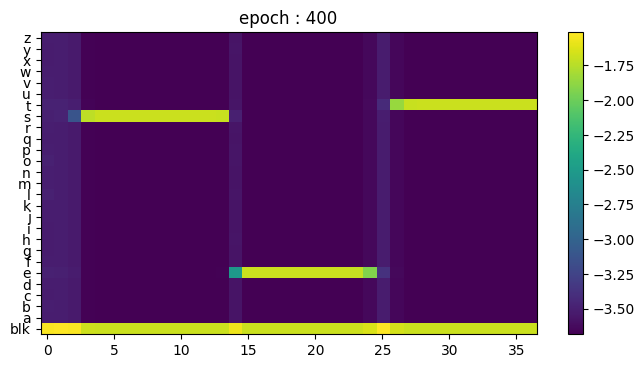

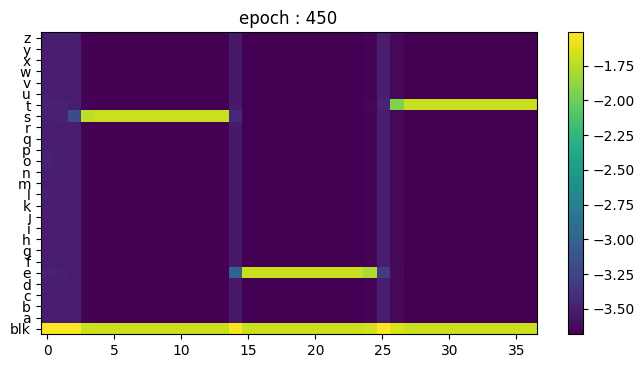

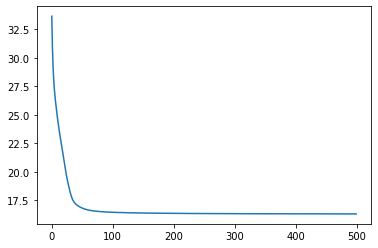

In [134]:
from tqdm.auto import tqdm


num_epoch = 500
ctc_loss = nn.CTCLoss()  # CTC loss, loss_fn

target = torch.tensor([[char_set['s'],char_set['e'],char_set['t']]],dtype=torch.int64)  # set -> 19,5,20
target_lengths=torch.tensor([[3]])  # target length = 3 
print(target,target_lengths)
y,sr = torchaudio.load("set.wav")  #datset 에 위치해야하는 statement 
batch = [[y,target]]
print(target.shape,target.dtype)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model=RNNModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
#out = torch.randn((37,27))
losses = []
#ctc_loss = nn.CTCLoss()
input_lengths = torch.tensor(37)

pbar = tqdm(range(num_epoch))
for e in  pbar:  
  for sample in batch:    
    x,y = sample
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    #print(input.shape)
    #pred = torch.argmax(input, dim=-1)
    #logit = torch.zeros_like(input).scatter_(1, pred.unsqueeze(1), 1.)    
    #input_lengths = torch.tensor([input.shape[1]])
    #print(pred.shape, target.shape, input_lengths, target_lengths)
    loss = ctc_loss(pred.squeeze(0), target, input_lengths, target_lengths)
    pbar.set_postfix({'loss': loss.item()})
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e % 50 == 0 : 
      plot_ctc(pred,e)
    
plt.plot(losses)

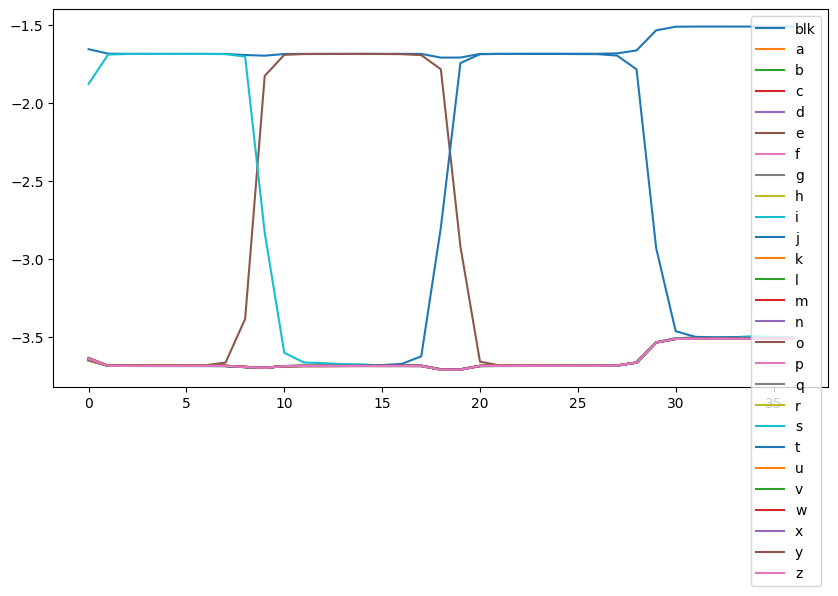

In [136]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(out[0].cpu().detach().numpy())
plt.legend(char_list)
plt.show()

In [141]:
??torch.exp

In [143]:
import plotly.graph_objects as go

data = torch.exp(out[0]).cpu().detach().numpy()
fig = go.Figure()
for idx, char_prob in enumerate(data.T):
  fig.add_trace(go.Line(y=char_prob, name=char_list[idx]))
fig.show()


/usr/local/lib/python3.8/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Q&A
```
Q : CTC에서 target에 있지 않은 blk의 확률값이 높은 이유는 무엇인가요
CTC에서 blk('_')는 shot pause, slience에 해당하는 확률이 될 수도 있고
apple, sorry 와 같이 같은 글자가 두번 나오는 경우에 pp_p, rr_r 과 같이 두 음을 
구분하는 역할도 하게 되므로 확률이 높게 추정됩니다.


그래서 이를 해결하고자 나온 새로운 loss 가 Facebook의 wav2letter모델을 위해 
제안한 auto segmentation criterion(ASG)가 있습니다.
다만 해당 criterion은 많이 사용되지는 않습니다.
```